# Data Preprocessing

In [1]:

import os
import random
import shutil
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Root folder containing the Kaggle dataset
root_folder = r'C:\Users\apurv\project 1\food41\images'

# Paths for training and testing subsets
train_folder = r'C:\Users\apurv\project 1\train'
test_folder = r'C:\Users\apurv\project 1\test'

# Number of images to select
selected_images_count = 1000


In [2]:

# Ensure valid extensions
valid_extensions = ('.jpg', '.jpeg', '.png')

# Gather all image paths from the dataset
all_images = []
for class_folder in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_folder)
    if os.path.isdir(class_path):
        all_images.extend([os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(valid_extensions)])

# Randomly select 1,000 images
selected_images = random.sample(all_images, selected_images_count)
print(f"Selected {len(selected_images)} images.")

# Create train and test directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Partition selected images into 80% train and 20% test
train_images, test_images = train_test_split(selected_images, test_size=0.2, random_state=42)

# Move selected images to train and test folders
def move_images(file_list, destination_folder):
    for img_path in file_list:
        class_name = os.path.basename(os.path.dirname(img_path))
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)
        shutil.copy(img_path, dest_class_folder)

move_images(train_images, train_folder)
move_images(test_images, test_folder)

print(f"Partitioned dataset: {len(train_images)} training images, {len(test_images)} testing images.")


Selected 1000 images.
Partitioned dataset: 800 training images, 200 testing images.


In [3]:

def compute_mean_std(folder):
    pixel_values = []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert('RGB')
            img_array = np.asarray(img) / 255.0
            pixel_values.append(img_array)

    all_pixels = np.concatenate([img.reshape(-1, 3) for img in pixel_values], axis=0)
    mean = all_pixels.mean(axis=0)
    std = all_pixels.std(axis=0)
    return mean, std

# Compute mean and std for training images
mean, std = compute_mean_std(train_folder)
print(f"Mean: {mean}, Std: {std}")


Mean: [0.5519003  0.44823274 0.35014757], Std: [0.26918766 0.27453568 0.27998201]


In [13]:
# Updated transforms to include resizing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])



In [10]:

# Create datasets using ImageFolder
train_dataset = ImageFolder(root=train_folder, transform=train_transforms)
test_dataset = ImageFolder(root=test_folder, transform=test_transforms)

# Split training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")


Training set size: 640
Validation set size: 160


In [6]:

batch_size = 32

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully.")


DataLoaders created successfully.


In [15]:
# Reload datasets with updated transforms
train_dataset = ImageFolder(root=train_folder, transform=train_transforms)
test_dataset = ImageFolder(root=test_folder, transform=test_transforms)

# Split train dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


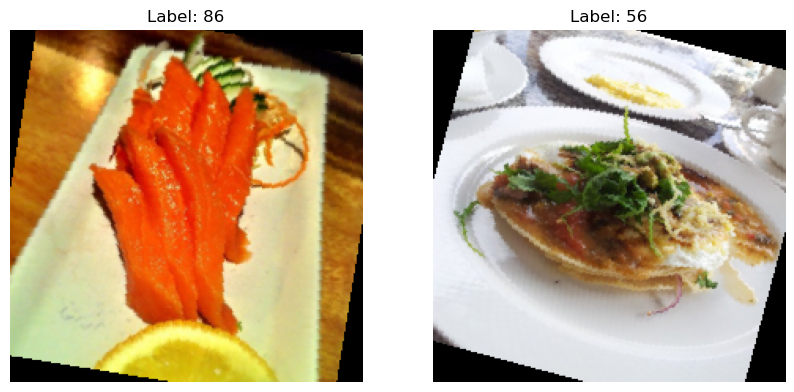

In [16]:
# Visualize two images from the DataLoader
def show_two_samples(loader, mean, std):
    """
    Visualize two images from the DataLoader with denormalization.
    """
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(2):
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
        img = img * std + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]
        ax[i].imshow(img)
        ax[i].set_title(f"Label: {labels[i]}")
        ax[i].axis('off')
    plt.show()

# Call the function
show_two_samples(train_loader, np.array(mean), np.array(std))


# Intial Network

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np


In [23]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the class
class TwoImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Replace these with paths to two specific images from your dataset
image_paths = [
    r'C:\Users\apurv\project 1\food41\images\apple_pie\134.jpg',
    r'C:\Users\apurv\project 1\food41\images\apple_pie\21063.jpg'
]

# Replace these with appropriate labels
labels = [0, 1]  # Example labels

# Load the images
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert to tensor
])

# Create the dataset and DataLoader
dataset = TwoImageDataset(images, labels, transform=transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Test the DataLoader
for batch_images, batch_labels in loader:
    print(f"Image batch shape: {batch_images.shape}")
    print(f"Labels batch: {batch_labels}")
    break



Image batch shape: torch.Size([2, 3, 224, 224])
Labels batch: tensor([0, 1])


In [25]:
class ConfigurableCNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes):
        super(ConfigurableCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3  # RGB images

        # Add convolutional layers
        for _ in range(num_layers):
            self.layers.append(
                nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1)
            )
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = num_filters

        # Add a fully connected layer
        self.fc = nn.Linear(num_filters * (224 // (2 ** num_layers))**2, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


In [26]:
# Hyperparameters
num_layers = 3
num_filters = 32
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
num_classes = 2
epochs = 50


In [27]:
# Initialize the model
model = ConfigurableCNN(num_layers=num_layers, num_filters=num_filters, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    accuracy = correct.item() / len(dataset)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Stop if the model overfits
    if accuracy == 1.0:
        print("Model has overfit the dataset!")
        break


Epoch 1/50, Loss: 0.6903, Accuracy: 0.5000
Epoch 2/50, Loss: 0.6809, Accuracy: 0.5000
Epoch 3/50, Loss: 0.6638, Accuracy: 0.5000
Epoch 4/50, Loss: 0.6398, Accuracy: 0.5000
Epoch 5/50, Loss: 0.6068, Accuracy: 1.0000
Model has overfit the dataset!


#  ClearML base task

In [28]:
pip install clearml


  Obtaining dependency information for clearml from https://files.pythonhosted.org/packages/69/0a/57b95f86bb868dbbabe49a8be162ee7c425e0338a3d23e20a3f1868ecf76/clearml-1.16.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for furl>=2.0.0 from https://files.pythonhosted.org/packages/41/ef/a572e03144d18842c480bd25165ec50ddc20b1744b2aeaaae4408a281f6f/furl-2.1.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pathlib2>=2.3.0 from https://files.pythonhosted.org/packages/09/eb/4af4bcd5b8731366b676192675221c5324394a580dfae469d498313b5c4a/pathlib2-2.3.7.post1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for referencing<0.40 from https://files.pythonhosted.org/packages/b7/59/2056f61236782a2c86b33906c025d4f4a0b17be0161b63b70fd9e8775d36/referencing-0.35.1-py3-none-any.whl.metadata
  Obtaining dependency information for orderedmultidict>=1.0.1 from https://files.pythonhosted.org/packages/04/16/5e95c70bda8fe6ea715005c0db8e602400bdba50ae3c72c

In [2]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=
%env CLEARML_API_SECRET_KEY=yQtfzF-

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=
env: CLEARML_API_SECRET_KEY=yQtfzF-


In [3]:
import clearml
clearml.browser_login()

ClearML automatic browser login failed, please login or create a new account
To get started with ClearML: setup your own `clearml-server`, or create a free account at https://app.clear.ml

Please login to https://app.clear.ml , then press [Enter] to connect apurvachavan125@gmail.com

We cannot connect automatically (adblocker / incognito?) 😟 
Please go to https://app.clear.ml/settings/workspace-configuration 
Then press  + Create new credentials  
And copy/paste your Access Key here:  MUHAVD0G7GSS30YZ71JFYDWC2ZDG7D
 Setting access key 
Now copy/paste your Secret Key here: 0u_w8YMzhYbyF9vF_yOf4vgSBnopbow5kumPiVpeSTYi3KJQ3OgBdr-P2oEHP82pPkk
 Setting secret key 


Hurrah! 🥳 🎊 🎉
🤖 ClearML connected successfully - let's build something! 🚀


In [6]:
from clearml import Task
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Step 1: Initialize ClearML Task
task = Task.init(project_name="My ClearML Project", task_name="Two Image Overfit Task")

# Step 2: Dataset Class
class TwoImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Step 3: Load Example Images
folder = r'C:\Users\apurv\project 1\food41\images\apple_pie'
valid_extensions = ('.jpg', '.jpeg', '.png')
image_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(valid_extensions)][:2]
labels = [0, 1]  # Replace with actual labels
images = [Image.open(img_path).convert('RGB') for img_path in image_paths]

# Step 4: Define Transforms and DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = TwoImageDataset(images, labels, transform=transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Step 5: Define the CNN Model
class ConfigurableCNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes):
        super(ConfigurableCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3

        for _ in range(num_layers):
            self.layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = num_filters

        self.fc = nn.Linear(num_filters * (224 // (2 ** num_layers))**2, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Step 6: Define Hyperparameters
hyperparameters = {
    "num_layers": 3,
    "num_filters": 32,
    "learning_rate": 0.01,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "epochs": 50,
}
task.connect(hyperparameters)

# Step 7: Initialize Model, Loss, and Optimizer
model = ConfigurableCNN(
    num_layers=hyperparameters["num_layers"],
    num_filters=hyperparameters["num_filters"],
    num_classes=2,
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=hyperparameters["learning_rate"],
    momentum=hyperparameters["momentum"],
    weight_decay=hyperparameters["weight_decay"],
)

# Step 8: Training Loop
for epoch in range(hyperparameters["epochs"]):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    accuracy = correct.item() / len(dataset)
    print(f"Epoch {epoch + 1}/{hyperparameters['epochs']}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Log metrics to ClearML
    task.get_logger().report_scalar("Loss", "Train", iteration=epoch, value=running_loss)
    task.get_logger().report_scalar("Accuracy", "Train", iteration=epoch, value=accuracy)

    if accuracy == 1.0:
        print("Model has overfit the dataset!")
        break

# Step 9: Save the Model
torch.save(model.state_dict(), "model_overfit.pth")
print("Training complete.")


Epoch 1/50, Loss: 0.7011, Accuracy: 0.5000
Epoch 2/50, Loss: 0.6859, Accuracy: 0.5000
Epoch 3/50, Loss: 0.6590, Accuracy: 1.0000
Model has overfit the dataset!
ClearML Monitor: Reporting detected, reverting back to iteration based reporting
Training complete.
